# MELodyGAN

MELodyGAN is a conditional DCGAN that generates Mel Spectrograms to be converted back to 30 second audio clips trained on the GTZAN dataset.

In [ ]:
# If data is stored in Google Drive:
from google.colab import drive
drive.mount('/content/drive')

drive_folder = '/content/drive/MyDrive/CS682' # Modify location if needed
%cd {drive_folder}

Mounted at /content/drive
/content/drive/MyDrive/CS682


In [ ]:
%%capture
!pip install torchaudio librosa boto3

## Helper Functions

Several helper functions.

### Audio Format Conversions

The following block of code defines useful helper functions for converting audio files (wav) into real-valued Power Spectrograms with n_fft = 2048, (number of Fast Fourier Transforms), then Mel Spectrograms, and back.

In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

from IPython.display import Audio

# (metadata from audio files)
sample_rate = 22050
sec = 10
channels = 1

# time = length of waveform = sec * sample_rate
# time = 10 * 22050 = 220500
time = 220500

# Number of Fast Fourier Transforms
n_fft = 2048

# Length of hop between STFT windows
hop_length = (n_fft // 4)

# Number of mel filter banks (Default 128)
n_mels = 128

# frames = sec * sample_rate / hop_length + 1
# frames = 10 * 22050 // 512 + 1 = 431
frames =  432

# Transform from waveforms into mel spectrograms
# (channels, time)
mel_spectrogram = T.MelSpectrogram(
    sample_rate = sample_rate,
    n_fft = n_fft,
    hop_length= hop_length,
    n_mels = n_mels
)

# Transform from spectrogram to waveform
griffin_lim = T.GriffinLim(
    n_fft = n_fft,
    hop_length = n_fft // 4
    )

# Transform from melspectrogram to spectrogram
inverse_melscale_transform = T.InverseMelScale(
    n_stft = n_fft // 2 + 1,
    n_mels = n_mels,
    sample_rate = sample_rate
    )

### Actual Helper Functions ###

# Function to load in waveform from a wav file location
# --> (channels, time)
def load_wav(file):
    waveform, sr = torchaudio.load(file)
    return waveform

# Function to convert waveform to a mel spectrogram
# (channels, time) --> (channels, n_mels, frames)
def wav_to_mel(wav):
    return mel_spectrogram(wav)

# Function to convert mel spectrograms back to waveforms
# (channels, n_mels, frames) --> (channels, time)
def mel_to_wav(mel):
    return griffin_lim(inverse_melscale_transform(mel))

# Useful function for just playing waveform in Notebook
def audio(wav):
    return Audio(wav.numpy(), rate = sample_rate)

### Additional Helper Functions

These are just for plotting.

In [ ]:
import librosa
import matplotlib.pyplot as plt

def plot_waveform(waveform, sr, title="Waveform", ax = None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [ ]:
# Testing pop00002.wav as example
wav = "/content/drive/MyDrive/CS682/Data/genres_original/rock/rock.00027.wav"

waveform, sr = torchaudio.load(wav)
waveform = waveform[:, 0:time]


mel = wav_to_mel(waveform)
reconstructed_waveform = mel_to_wav(mel)

print("Raw Waveform Shape:")
print(waveform.shape)
print("Melspectrogram Shape:")
print(mel.shape)
print("Reconstructed Waveform Shape:")
print(reconstructed_waveform.shape)

Raw Waveform Shape:
torch.Size([1, 220500])
Melspectrogram Shape:
torch.Size([1, 128, 431])
Reconstructed Waveform Shape:
torch.Size([1, 220160])


In [ ]:
# Comparing original audios with reconstructed audios

# Original audio:
audio(waveform)

In [ ]:
# Reconstructed audio: 2048 ffts
audio(reconstructed_waveform)

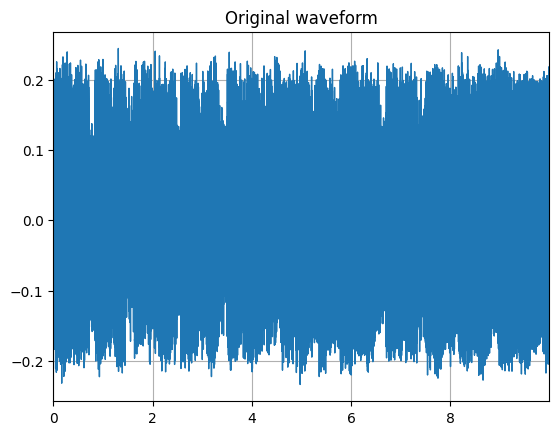

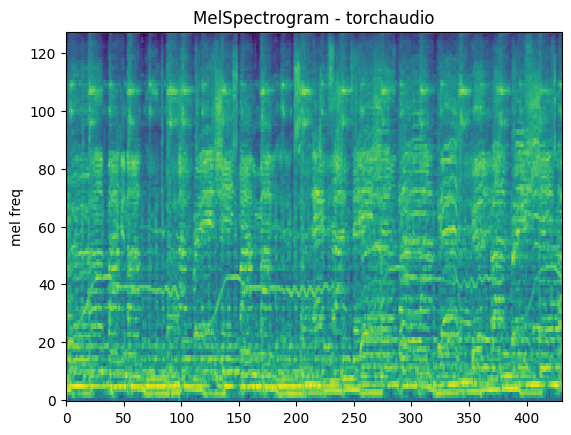

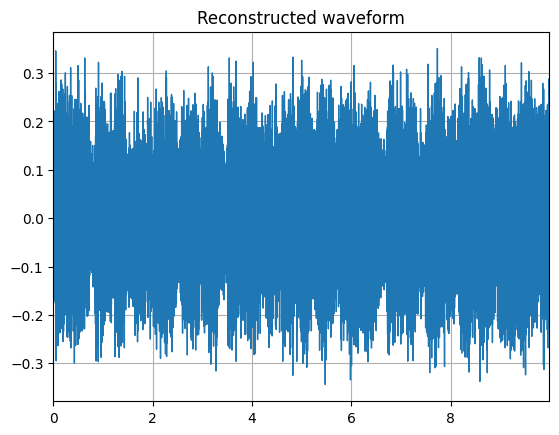

In [ ]:
# Some plots
plot_waveform(waveform, sr, title="Original waveform")
plot_spectrogram(mel[0], title="MelSpectrogram - torchaudio", ylabel= "mel freq")
plot_waveform(reconstructed_waveform, sr, title="Reconstructed waveform")

## Dataloader

Time to actually load some training data for the GAN.

### Preprocessing

Only need to run this if spectrogram.pt is not already saved.

In [ ]:
# Thankfully this only needs to be run once

import glob
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

audio_dir = drive_folder + '/Data/genres_original'

# maps for index to genres and vice versa
genre_to_ix = {}
ix_to_genre = {}

c = 0
# large tensor to store spectrograms for all 10 genres
# (genres, num, n_mels, frames)
spectrograms = torch.empty((10, 100, 1, n_mels, frames))

# Create a genre
for fold in glob.glob(f"{audio_dir}/*"):

    # genre: genre name from the current folder
    genre = os.path.basename(fold)

    # tensor to store all 100 melspectrograms for current specific genre:
    genre_spectrograms = torch.empty((100, 1, n_mels, frames))
    i = 0

    # Add all 100 mel spectrograms for specific genre to genre_spectrograms
    for wav in glob.glob(f"{audio_dir}/{genre}/*.wav"):

        # Stacking over channel dimension
        waveform, _ = torchaudio.load(wav)
        # Truncate down waveform to first 10 seconds
        mel = wav_to_mel(waveform[:, :time])

        # One of the audio files in jazz is actually two channeled!
        if mel.shape[0] > 1:
            mel = torch.sum(mel, dim = 0)

        genre_spectrograms[i] = mel
        i += 1

    ix_to_genre[c] = genre
    genre_to_ix[genre] = c
    spectrograms[c] = genre_spectrograms
    c += 1

# (classes, N, C = channel, mel_bins = 128, frames = 431) technically 431 ~ 43 Hz
print(spectrograms.shape)
print(genre_to_ix)
print(ix_to_genre)

torch.save(spectrograms, 'spectrograms_10.pt')

torch.Size([10, 100, 1, 128, 431])
{'pop': 0, 'blues': 1, 'metal': 2, 'rock': 3, 'classical': 4, 'country': 5, 'hiphop': 6, 'reggae': 7, 'disco': 8, 'jazz': 9}
{0: 'pop', 1: 'blues', 2: 'metal', 3: 'rock', 4: 'classical', 5: 'country', 6: 'hiphop', 7: 'reggae', 8: 'disco', 9: 'jazz'}


### Loading Data

In [ ]:
# Imports and globals
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

In [ ]:
# Intialize saved data and reinitialize maps
spectrograms = torch.load('spectrograms_10.pt')
spectrograms.to(device)

genre_to_ix = {'pop': 0, 'blues': 1, 'metal': 2, 'rock': 3, 'classical': 4, 'country': 5, 'hiphop': 6, 'reggae': 7, 'disco': 8, 'jazz': 9}
ix_to_genre = {0: 'pop', 1: 'blues', 2: 'metal', 3: 'rock', 4: 'classical', 5: 'country', 6: 'hiphop', 7: 'reggae', 8: 'disco', 9: 'jazz'}

In [ ]:
BATCH_SIZE = 10
batches = 100 // BATCH_SIZE
# Spectrograms_10.shape = (10, 100, 1, 128, 431)

batch_spectrograms = spectrograms.reshape(10, batches, BATCH_SIZE, 1, 128, 431).to(device)

print(batch_spectrograms[genre_to_ix['jazz']].shape)  # (batches, BATCH_SIZE, C, H, W)

torch.Size([10, 10, 1, 128, 431])


## GAN Architecture

### Generator + Random Noise Sampler

In [ ]:
Z_DIM = 100

# (N, D) --> (N, D)
def get_noise(n_samples, z_dim = Z_DIM, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn((n_samples, z_dim), device = device)

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector (10)
        im_chan: the number of channels in the images (1)
        hidden_dim: the inner dimension (variable, 32)
    '''
    def __init__(self, z_dim = Z_DIM, im_chan = 1, hidden_dim = 16):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        print(self.z_dim)

        # C = hidden_dim, Z = z_dim
        self.gen = nn.Sequential(
            # (Z, 1, 1) --> (4C, 30, 55)
            self.make_gen_block(self.z_dim, hidden_dim * 4, kernel_size = (30, 55)),
            # (4C, 30, 55) --> (2C, 31, 97)
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size = (2, 43), stride = 1),
            #(2C, 31, 97) --> (C, 63, 195)
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            # (C, 63, 195) --> (1, 128, 431)
            self.make_gen_block(hidden_dim, im_chan, kernel_size=(4, 43), final_layer=True),
        )

    # ConvTranspose2d --> BatchNorm2d --> LeakyReLU, last layer: ConvTranspose2d --> ReLU
    def make_gen_block(self, input_channels, output_channels, kernel_size = 3, stride = 2, final_layer = False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        '''
        #     Steps:
        #       1: Do a transposed convolution using the given parameters.
        #       2: Do a batchnorm, except for the last layer.
        #       3: Follow each batchnorm with a LeakyReLU activation.
        #       4: its the final layer, use a ReLU activation after the deconvolution

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.02, inplace = True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.ReLU()
            )

    # (N, Z) --> (N, Z, 1, 1)
    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        n, z = noise.shape

        return noise.view(n, z, 1, 1).to(device)

    # (N, Z) --> (N, 1, 128, 431)
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

### Discriminator

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, im_chan = 1, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # (1, 128, 431) --> (C, 63, 195)
            self.make_disc_block(im_chan, hidden_dim, kernel_size = (4, 43)),
            # (C, 63, 195) --> (2C, 30, 77)
            self.make_disc_block(hidden_dim, hidden_dim * 2, kernel_size = (4, 43)),
            # (2C, 30, 77) --> (1, 1, 1)
            self.make_disc_block(hidden_dim * 2, 1, kernel_size = (30, 77), stride = 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1: Add a convolutional layer using the given parameters.
        #       2: Do a batchnorm, except for the last layer.
        #       3: Follow each batchnorm with a LeakyReLU activation with slope 0.2.


        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Loss Functions

In [ ]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function in PyTorch.

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    bce = nn.BCEWithLogitsLoss()
    output = bce(input.squeeze(), target)
    return output

def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.

    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = 0.5 * torch.mean((scores_real - 1)**2) + 0.5 * torch.mean((scores_fake)**2)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.

    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = 0.5 * torch.mean((scores_fake - 1)**2)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

## Run the GAN

In [ ]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, batch_spectrograms, show_every=250,
              batch_size = 100, noise_size = 100, num_epochs = 10):
    """
    Train a GAN!

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - genres_data: dictionary that stores (genre, numpy array)
    """
    images = []
    iter_count = 0

    for epoch in range(num_epochs):

            # TRAIN ONE GENRE AT A TIME
            genre = "pop"
            idx = genre_to_ix[genre]

            # Loop over batches
            # batches only for genre = "blues"
            batches = batch_spectrograms[idx] # (batches, batch_size, 1, 128, 431)
            batch_num = batches.shape[0]

            for batch in range(batch_num):

                x = batches[batch]
                x.to(device)

                # Discriminator step
                D_solver.zero_grad()
                real_data = x
                logits_real = D(2* (real_data - 0.5))

                g_fake_seed = get_noise(batch_size, noise_size).to(device)
                fake_images = G(g_fake_seed).detach()
                logits_fake = D(fake_images)

                d_total_error = discriminator_loss(logits_real, logits_fake)
                d_total_error.backward()
                D_solver.step()

                # Generator step
                G_solver.zero_grad()
                g_fake_seed = get_noise(batch_size, noise_size).to(device)
                fake_images = G(g_fake_seed)

                # print(fake_images.shape)

                gen_logits_fake = D(fake_images)
                g_error = generator_loss(gen_logits_fake)
                g_error.backward()
                G_solver.step()

                if (iter_count % show_every == 0):
                    print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                    imgs = fake_images.data.cpu()
                    images.append(imgs[0:16])

                iter_count += 1

    return images

In [ ]:
import torch.optim as optim



def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.

    Input:
    - model: A PyTorch model that we want to optimize.

    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    return optimizer

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

D = Discriminator().to(device)
G = Generator().to(device)

# G = G.apply(weights_init)
# D = D.apply(weights_init)


D_solver = get_optimizer(D) #optim.Adam(lr=1e-3)
G_solver = get_optimizer(G) #optim.Adam(lr=1e-3)

discriminator_loss = ls_discriminator_loss
generator_loss = ls_generator_loss

100


In [ ]:
images = run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, batch_spectrograms, show_every = 1,
              batch_size = BATCH_SIZE, noise_size = 100, num_epochs = 100)

Iter: 0, D: 1.251, G:0.5895
Iter: 1, D: 0.7924, G:1.018
Iter: 2, D: 0.6565, G:2.981
Iter: 3, D: 1.594, G:2.511
Iter: 4, D: 3.231, G:6.548
Iter: 5, D: 4.103, G:5.977
Iter: 6, D: 3.64, G:2.594
Iter: 7, D: 5.357, G:1.96
Iter: 8, D: 1.95, G:0.5613
Iter: 9, D: 0.8643, G:1.423
Iter: 10, D: 0.804, G:0.2627
Iter: 11, D: 0.4402, G:0.4825
Iter: 12, D: 0.6268, G:2.491
Iter: 13, D: 2.29, G:1.09
Iter: 14, D: 3.086, G:3.473
Iter: 15, D: 2.63, G:2.177
Iter: 16, D: 3.592, G:0.6733
Iter: 17, D: 1.359, G:1.951
Iter: 18, D: 2.68, G:5.139
Iter: 19, D: 4.957, G:1.589
Iter: 20, D: 3.767, G:1.487
Iter: 21, D: 3.595, G:0.5069
Iter: 22, D: 5.496, G:9.274
Iter: 23, D: 8.49, G:2.97
Iter: 24, D: 3.877, G:1.008
Iter: 25, D: 3.284, G:1.916
Iter: 26, D: 2.302, G:1.325
Iter: 27, D: 0.8264, G:1.878
Iter: 28, D: 1.671, G:2.06
Iter: 29, D: 1.072, G:1.085
Iter: 30, D: 2.654, G:1.435
Iter: 31, D: 1.613, G:0.8963
Iter: 32, D: 3.547, G:1.465
Iter: 33, D: 2.919, G:1.753
Iter: 34, D: 5.191, G:3.417
Iter: 35, D: 4.631, G:4.982

1000
torch.Size([1, 100])
torch.Size([1, 1, 128, 431])
torch.Size([10, 1, 128, 431])


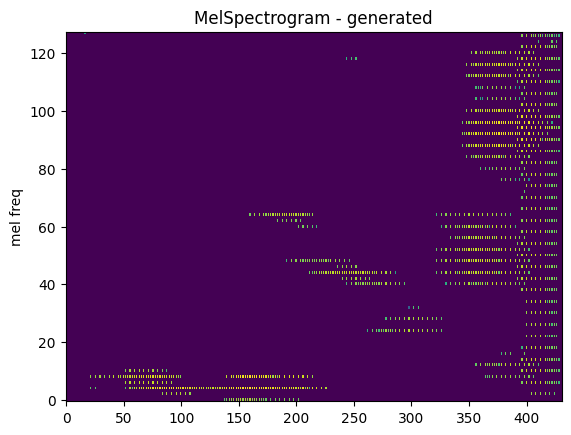

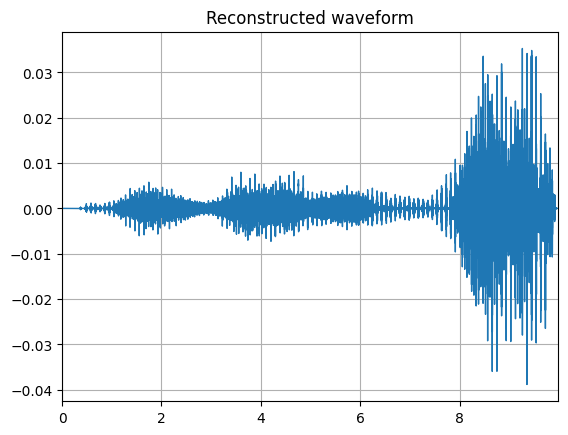

In [ ]:
print(len(images))

g_fake_seed = get_noise(1, Z_DIM)

print(g_fake_seed.shape)

fake_batch_images = G(g_fake_seed).detach().cpu()
print(fake_batch_images.shape)

# 10 fakes at final iteration
print(images[0].shape)

# First fake
#example = images[0][0]
example = fake_batch_images[0]
example_wav = mel_to_wav(example)

# Some plots
plot_spectrogram(example[0], title="MelSpectrogram - generated", ylabel= "mel freq")
plot_waveform(example_wav, sample_rate, title="Reconstructed waveform")

audio(example_wav)